In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models import squeezenet1_1

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics
from torchinfo import summary

import cv2

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_pretrained/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('SqueezeNet Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

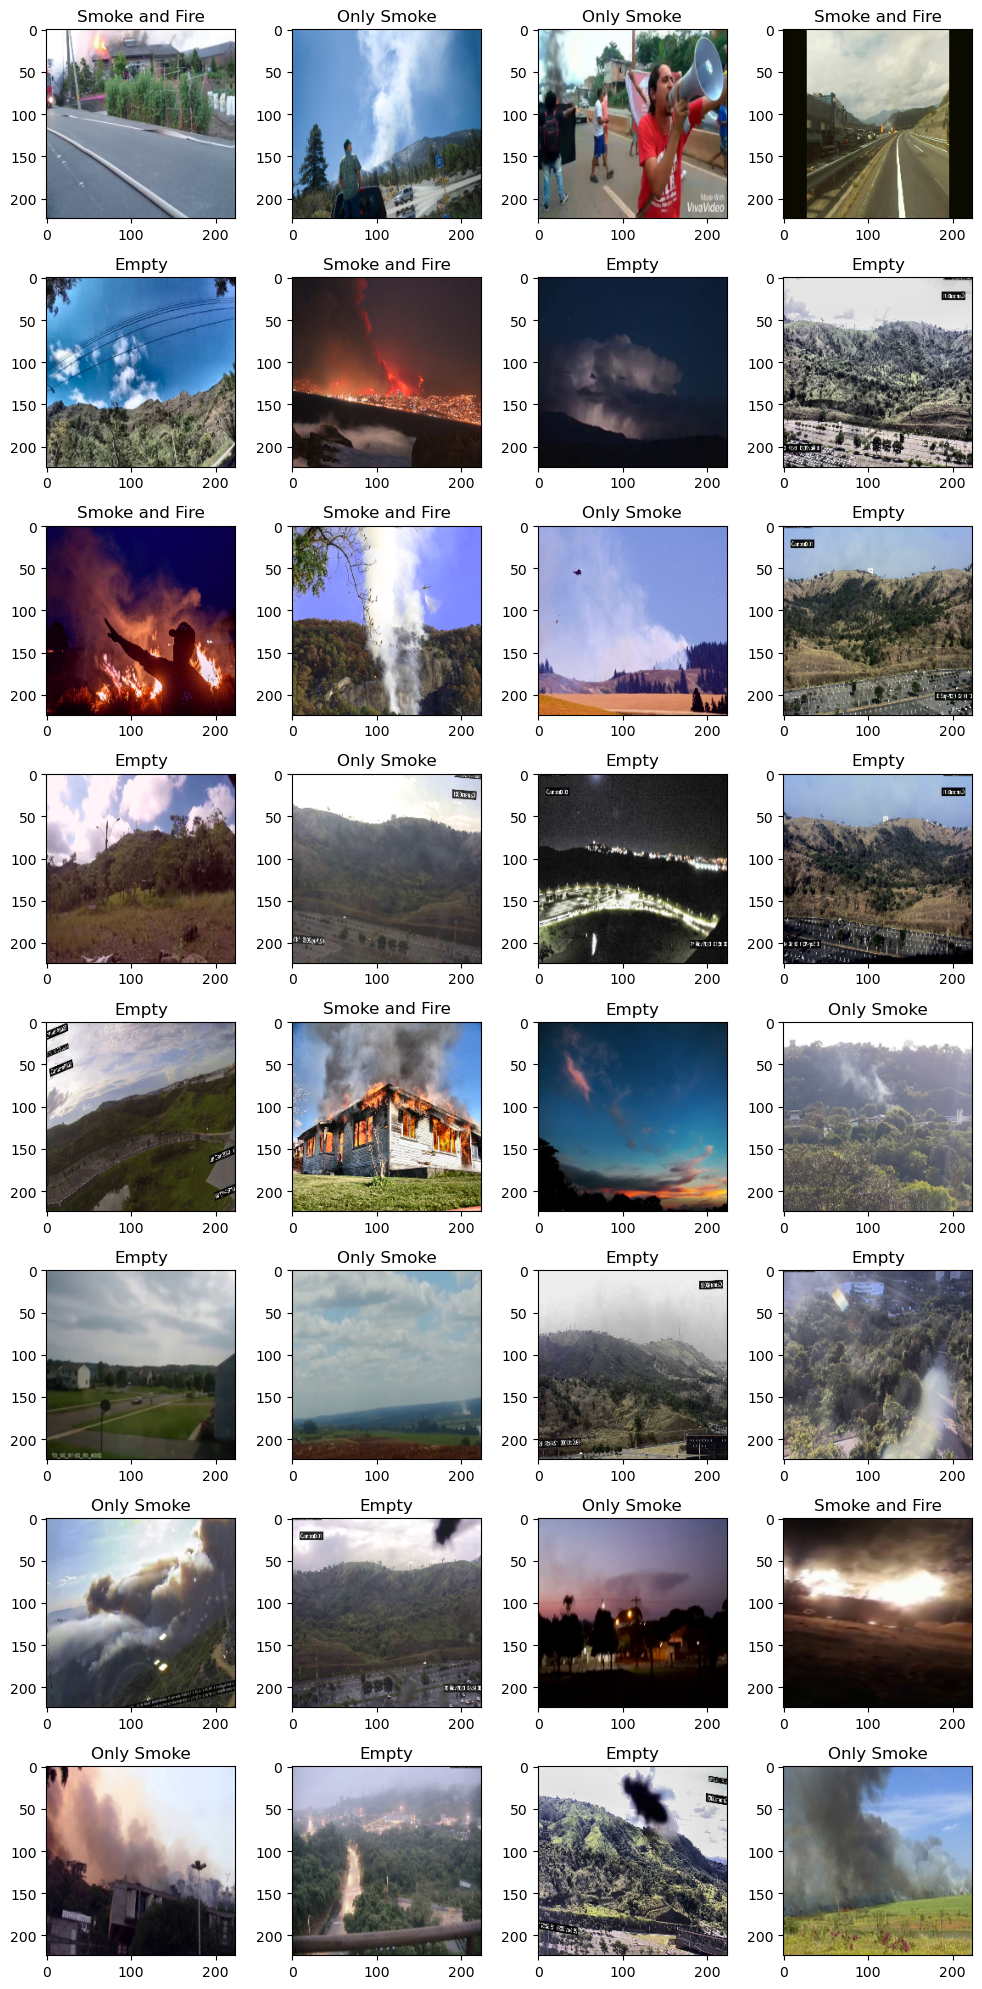

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: SqueezeNet Pretrained

In [10]:
class PRETRAINED_SQUEEZENET(nn.Module):
    def __init__(self, base_model, last_channels, num_classes, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.last_channels = last_channels
        
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

    # TODO: initizalize only head layers
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_in',
    #                 nonlinearity='relu'
    #             )
    #             if m.bias is not None:
    #                     nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

#MODEL = "BED"
MODEL = "SQUEENET1_1"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 20 #100
NUM_WORKERS = 8
PIN_MEMORY = True
PRETRAINED = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    #LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"
    LOAD_MODEL_FILE = "squeezeNet/" + "SQUEEZE_best_classifier.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

In [13]:
# base_model = squeezenet1_1(pretrained=True)

# Model Setup

In [14]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''

def setup_model(pretrained, load, model_name):
    if pretrained == True:
        if model_name == "SQUEENET1_1":
            print("Using SQUEENET1_1 Classifier")
            logger.info("Using SQUEENET1_1 Classifier")
        
            base_model = squeezenet1_1(weights='SqueezeNet1_1_Weights.DEFAULT')
            print(list(base_model.children())[-1])
            for name, layer in base_model.named_modules():
                if isinstance(layer, nn.Linear):
                    last_channels = layer.in_features
                    print(f'Model Pretrained has {last_channels} in features in last layer')
                    logger.info(f'Model Pretrained has {last_channels} in features in last layer')
            for param in base_model.parameters():
                param.requires_grad = False
            
            model = PRETRAINED_SQUEEZENET(base_model, last_channels=512, num_classes=N_CLASSES).to(DEVICE)   

            return model
    else:
        print("Wrong Model")
        logger.info("Wrong Model")
        raise SystemExit("Wrong Model")

model = setup_model(pretrained=PRETRAINED, load=LOAD_MODEL, model_name=MODEL)
model.eval()

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using SQUEENET1_1 Classifier
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)
Model shape is tensor([[-0.0058, -0.2323],
        [-0.0391, -0.2592],
        [-0.0588, -0.1505],
        [-0.1241, -0.1666]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
PRETRAINED_SQUEEZENET(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

# Torchinfo

In [15]:
model.eval()
print(summary(model, input_size=(1, 3, 224, 224)))
logger.info(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
PRETRAINED_SQUEEZENET                    [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 13, 13]          --
│    └─Sequential: 2-1                   [1, 512, 13, 13]          --
│    │    └─Conv2d: 3-1                  [1, 64, 111, 111]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 111, 111]         --
│    │    └─MaxPool2d: 3-3               [1, 64, 55, 55]           --
│    │    └─Fire: 3-4                    [1, 128, 55, 55]          (11,408)
│    │    └─Fire: 3-5                    [1, 128, 55, 55]          (12,432)
│    │    └─MaxPool2d: 3-6               [1, 128, 27, 27]          --
│    │    └─Fire: 3-7                    [1, 256, 27, 27]          (45,344)
│    │    └─Fire: 3-8                    [1, 256, 27, 27]          (49,440)
│    │    └─MaxPool2d: 3-9               [1, 256, 13, 13]          --
│    │    └─Fire: 3-10                   [1, 384, 13, 13

# Metrics

In [16]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [17]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [18]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [19]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Main Function

In [20]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {DEVICE}')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
print(f'W: {IMG_W}\nH: {IMG_H}')

logger.info(f'Device: {DEVICE}')
logger.info(f'Learning Rate: {LEARNING_RATE}')
logger.info(f'Weight Decay: {WEIGHT_DECAY}')
logger.info(f'Batch Size: {BATCH_SIZE}')
logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
logger.info(f'W: {IMG_W}\nH: {IMG_H}')

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224


## Loss Funtion Setup

In [21]:
# LOSS FUNCTION
if LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    loss_fn = BCE_LOSS(device=DEVICE)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE


In [22]:
def train_model(model, model_name, optimizer, scheduler, first_epoch=0, epochs = EPOCHS):
   
    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = first_epoch

    if LOAD_MODEL == False:
        if model_name == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif model_name == "SQUEEZE":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        else: 
            print("Pretrained Weights")
            logger.info("Pretrained Weights")            
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, start_epoch + epochs):

        print(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{start_epoch + epochs-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + model_name + "_Temp_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + model_name + '_best_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + model_name + '_last_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [23]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model, 
                               model_name=MODEL+'_FREEZE_',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               epochs = EPOCHS)

Starting script


***Start Training: 14:46:37

Pretrained Weights

=== EPOCH 0/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.301      |37.886      |20.415      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.198      |34.085      |16.113      

SMOKE -> Precision: 0.749 - Recall: 0.685 - Accuracy: 0.738 - F1: 0.716
FIRE -> Precision: 0.794 - Recall: 0.845 - Accuracy: 0.903 - F1: 0.819

Saving model with new best validation loss: 50.198

=== EPOCH 1/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.721      |34.353      |17.367      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.277      |32.588      |13.688      

SMOKE -> Precision: 0.857 - Recall: 0.539 - Accuracy: 0.735 - F1: 0.661
FIRE -> Precision: 0.900 - Recall: 0.766 - Accuracy: 0.917 - F1: 0.828

Saving model with new best validation loss: 46.277

=== EPOCH 2/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.707      |32.462      |16.245      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.996      |30.692      |13.304      

SMOKE -> Precision: 0.852 - Recall: 0.584 - Accuracy: 0.751 - F1: 0.693
FIRE -> Precision: 0.880 - Recall: 0.811 - Accuracy: 0.922 - F1: 0.844

Saving model with new best validation loss: 43.996

=== EPOCH 3/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.247      |31.690      |15.557      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.857      |29.423      |12.433      

SMOKE -> Precision: 0.783 - Recall: 0.756 - Accuracy: 0.781 - F1: 0.769
FIRE -> Precision: 0.875 - Recall: 0.832 - Accuracy: 0.926 - F1: 0.853

Saving model with new best validation loss: 41.857

=== EPOCH 4/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.830      |30.713      |15.117      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.725      |27.843      |11.882      

SMOKE -> Precision: 0.817 - Recall: 0.747 - Accuracy: 0.798 - F1: 0.780
FIRE -> Precision: 0.882 - Recall: 0.834 - Accuracy: 0.928 - F1: 0.857

Saving model with new best validation loss: 39.725

=== EPOCH 5/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.106      |30.028      |15.078      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.874      |27.186      |11.689      

SMOKE -> Precision: 0.846 - Recall: 0.715 - Accuracy: 0.800 - F1: 0.775
FIRE -> Precision: 0.934 - Recall: 0.795 - Accuracy: 0.932 - F1: 0.859

Saving model with new best validation loss: 38.874

=== EPOCH 6/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.087      |29.669      |14.418      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.845      |27.265      |11.580      

SMOKE -> Precision: 0.860 - Recall: 0.722 - Accuracy: 0.810 - F1: 0.785
FIRE -> Precision: 0.872 - Recall: 0.857 - Accuracy: 0.930 - F1: 0.864

Saving model with new best validation loss: 38.845

=== EPOCH 7/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.146      |29.054      |14.092      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.881      |26.496      |11.385      

SMOKE -> Precision: 0.828 - Recall: 0.787 - Accuracy: 0.819 - F1: 0.807
FIRE -> Precision: 0.871 - Recall: 0.867 - Accuracy: 0.932 - F1: 0.869

Saving model with new best validation loss: 37.881

=== EPOCH 8/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.004      |28.245      |13.760      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.560      |25.602      |10.958      

SMOKE -> Precision: 0.819 - Recall: 0.801 - Accuracy: 0.819 - F1: 0.810
FIRE -> Precision: 0.900 - Recall: 0.841 - Accuracy: 0.935 - F1: 0.870

Saving model with new best validation loss: 36.560

=== EPOCH 9/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.583      |27.946      |13.637      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.386      |25.159      |11.226      

SMOKE -> Precision: 0.847 - Recall: 0.785 - Accuracy: 0.828 - F1: 0.815
FIRE -> Precision: 0.934 - Recall: 0.802 - Accuracy: 0.934 - F1: 0.863

Saving model with new best validation loss: 36.386

=== EPOCH 10/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.087      |27.418      |13.669      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.456      |24.908      |10.548      

SMOKE -> Precision: 0.835 - Recall: 0.785 - Accuracy: 0.822 - F1: 0.809
FIRE -> Precision: 0.892 - Recall: 0.867 - Accuracy: 0.938 - F1: 0.879

Saving model with new best validation loss: 35.456

=== EPOCH 11/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.381      |27.323      |13.058      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.799      |25.227      |10.572      

SMOKE -> Precision: 0.879 - Recall: 0.716 - Accuracy: 0.816 - F1: 0.789
FIRE -> Precision: 0.926 - Recall: 0.838 - Accuracy: 0.941 - F1: 0.880

=== EPOCH 12/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.506      |27.520      |12.987      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.417      |24.844      |10.573      

SMOKE -> Precision: 0.855 - Recall: 0.751 - Accuracy: 0.819 - F1: 0.799
FIRE -> Precision: 0.881 - Recall: 0.885 - Accuracy: 0.939 - F1: 0.883

Saving model with new best validation loss: 35.417

=== EPOCH 13/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.965      |27.158      |12.807      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.829      |24.179      |10.650      

SMOKE -> Precision: 0.836 - Recall: 0.825 - Accuracy: 0.838 - F1: 0.830
FIRE -> Precision: 0.873 - Recall: 0.886 - Accuracy: 0.937 - F1: 0.880

Saving model with new best validation loss: 34.829

=== EPOCH 14/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.494      |26.964      |12.530      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.622      |24.699      |10.923      

SMOKE -> Precision: 0.878 - Recall: 0.727 - Accuracy: 0.820 - F1: 0.795
FIRE -> Precision: 0.940 - Recall: 0.795 - Accuracy: 0.934 - F1: 0.862

=== EPOCH 15/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.387      |26.748      |12.639      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.602      |24.265      |10.337      

SMOKE -> Precision: 0.850 - Recall: 0.777 - Accuracy: 0.827 - F1: 0.812
FIRE -> Precision: 0.898 - Recall: 0.867 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 34.602

=== EPOCH 16/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.008      |26.544      |12.464      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.196      |23.860      |10.336      

SMOKE -> Precision: 0.837 - Recall: 0.817 - Accuracy: 0.836 - F1: 0.827
FIRE -> Precision: 0.903 - Recall: 0.859 - Accuracy: 0.940 - F1: 0.880

Saving model with new best validation loss: 34.196

=== EPOCH 17/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.818      |26.307      |12.511      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.029      |23.884      |10.145      

SMOKE -> Precision: 0.864 - Recall: 0.776 - Accuracy: 0.833 - F1: 0.817
FIRE -> Precision: 0.940 - Recall: 0.829 - Accuracy: 0.942 - F1: 0.881

Saving model with new best validation loss: 34.029

=== EPOCH 18/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.348      |26.054      |12.294      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.629      |23.636      |9.993       

SMOKE -> Precision: 0.889 - Recall: 0.733 - Accuracy: 0.828 - F1: 0.804
FIRE -> Precision: 0.905 - Recall: 0.872 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 33.629

=== EPOCH 19/19 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.232      |26.076      |12.157      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.363      |22.516      |9.847       

SMOKE -> Precision: 0.863 - Recall: 0.812 - Accuracy: 0.847 - F1: 0.837
FIRE -> Precision: 0.935 - Recall: 0.843 - Accuracy: 0.944 - F1: 0.887

Saving model with new best validation loss: 32.363

***Script finished: 14:55:04

Time elapsed: 0:08:26.487522


# Plot Results

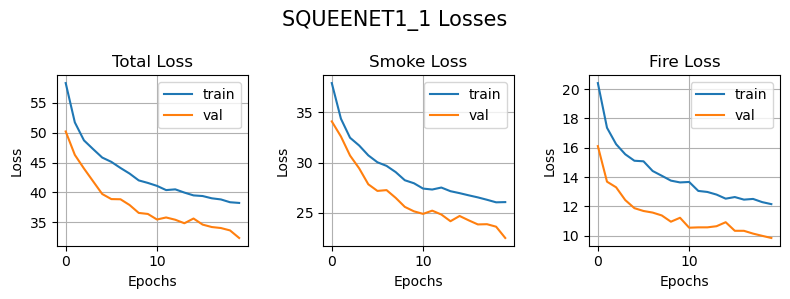

In [24]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()

# Fine Tuning

In [25]:
FIRST_EPOCH = EPOCHS
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
EPOCHS = 100 

In [26]:
for param in model_freeze.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_freeze.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-7)
# MODEL PARAMETERS
model.eval()
n_trainable = sum(p.numel() for p in model_freeze.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model_freeze.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')


Trainable parameters = 738946
Total parameters = 738946



In [27]:
if __name__ == "__main__":
    print("Starting Fine Tuning\n")
    logger.info("Starting script\n")
    model_freeze = train_model(model=model_freeze, 
                               model_name=MODEL+'_FineTune',
                               optimizer=optimizer, 
                               scheduler=scheduler, 
                               first_epoch = FIRST_EPOCH,
                               epochs = EPOCHS)

Starting Fine Tuning


***Start Training: 14:55:05

Pretrained Weights

=== EPOCH 20/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 12.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.372      |24.832      |10.540      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.732      |21.823      |8.909       

SMOKE -> Precision: 0.859 - Recall: 0.827 - Accuracy: 0.852 - F1: 0.843
FIRE -> Precision: 0.948 - Recall: 0.867 - Accuracy: 0.953 - F1: 0.905

Saving model with new best validation loss: 30.732

=== EPOCH 21/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.466      |23.471      |9.995       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.076      |20.842      |8.234       

SMOKE -> Precision: 0.857 - Recall: 0.850 - Accuracy: 0.860 - F1: 0.853
FIRE -> Precision: 0.930 - Recall: 0.904 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 29.076

=== EPOCH 22/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.090      |22.800      |9.290       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.412      |20.377      |8.034       

SMOKE -> Precision: 0.870 - Recall: 0.852 - Accuracy: 0.867 - F1: 0.861
FIRE -> Precision: 0.940 - Recall: 0.896 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 28.412

=== EPOCH 23/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.335      |22.544      |8.791       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.944      |20.117      |7.827       

SMOKE -> Precision: 0.873 - Recall: 0.848 - Accuracy: 0.868 - F1: 0.861
FIRE -> Precision: 0.942 - Recall: 0.898 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 27.944

=== EPOCH 24/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.790      |22.073      |8.717       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.471      |19.752      |7.718       

SMOKE -> Precision: 0.872 - Recall: 0.859 - Accuracy: 0.871 - F1: 0.865
FIRE -> Precision: 0.921 - Recall: 0.914 - Accuracy: 0.957 - F1: 0.917

Saving model with new best validation loss: 27.471

=== EPOCH 25/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.203      |21.686      |8.517       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.886      |19.358      |7.528       

SMOKE -> Precision: 0.886 - Recall: 0.848 - Accuracy: 0.874 - F1: 0.867
FIRE -> Precision: 0.949 - Recall: 0.900 - Accuracy: 0.962 - F1: 0.924

Saving model with new best validation loss: 26.886

=== EPOCH 26/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.321      |21.094      |8.227       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.314      |19.028      |7.286       

SMOKE -> Precision: 0.886 - Recall: 0.854 - Accuracy: 0.877 - F1: 0.870
FIRE -> Precision: 0.944 - Recall: 0.907 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 26.314

=== EPOCH 27/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.677      |20.494      |8.183       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.877      |18.693      |7.184       

SMOKE -> Precision: 0.869 - Recall: 0.889 - Accuracy: 0.882 - F1: 0.879
FIRE -> Precision: 0.936 - Recall: 0.914 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 25.877

=== EPOCH 28/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.398      |20.369      |8.028       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.573      |18.346      |7.227       

SMOKE -> Precision: 0.872 - Recall: 0.882 - Accuracy: 0.881 - F1: 0.877
FIRE -> Precision: 0.936 - Recall: 0.912 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 25.573

=== EPOCH 29/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.013      |20.169      |7.844       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.918      |18.725      |7.193       

SMOKE -> Precision: 0.887 - Recall: 0.857 - Accuracy: 0.878 - F1: 0.871
FIRE -> Precision: 0.937 - Recall: 0.920 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 30/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.584      |19.791      |7.793       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.035      |17.969      |7.067       

SMOKE -> Precision: 0.879 - Recall: 0.887 - Accuracy: 0.887 - F1: 0.883
FIRE -> Precision: 0.948 - Recall: 0.907 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 25.035

=== EPOCH 31/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.054      |19.613      |7.442       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.062      |18.000      |7.062       

SMOKE -> Precision: 0.881 - Recall: 0.881 - Accuracy: 0.885 - F1: 0.881
FIRE -> Precision: 0.942 - Recall: 0.913 - Accuracy: 0.963 - F1: 0.927

=== EPOCH 32/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.768      |19.324      |7.443       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.629      |17.755      |6.874       

SMOKE -> Precision: 0.878 - Recall: 0.885 - Accuracy: 0.885 - F1: 0.881
FIRE -> Precision: 0.943 - Recall: 0.910 - Accuracy: 0.962 - F1: 0.926

Saving model with new best validation loss: 24.629

=== EPOCH 33/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.256      |19.105      |7.150       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.534      |17.615      |6.920       

SMOKE -> Precision: 0.879 - Recall: 0.890 - Accuracy: 0.888 - F1: 0.884
FIRE -> Precision: 0.948 - Recall: 0.904 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 24.534

=== EPOCH 34/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.881      |18.799      |7.082       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.280      |17.500      |6.779       

SMOKE -> Precision: 0.891 - Recall: 0.872 - Accuracy: 0.887 - F1: 0.881
FIRE -> Precision: 0.944 - Recall: 0.915 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 24.280

=== EPOCH 35/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.899      |18.556      |7.343       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.115      |17.477      |6.638       

SMOKE -> Precision: 0.870 - Recall: 0.908 - Accuracy: 0.891 - F1: 0.889
FIRE -> Precision: 0.940 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 24.115

=== EPOCH 36/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.425      |18.353      |7.072       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.951      |17.314      |6.637       

SMOKE -> Precision: 0.888 - Recall: 0.878 - Accuracy: 0.888 - F1: 0.883
FIRE -> Precision: 0.944 - Recall: 0.920 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 23.951

=== EPOCH 37/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.115      |18.134      |6.981       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.627      |17.052      |6.575       

SMOKE -> Precision: 0.892 - Recall: 0.883 - Accuracy: 0.892 - F1: 0.888
FIRE -> Precision: 0.939 - Recall: 0.927 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 23.627

=== EPOCH 38/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.945      |17.956      |6.989       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.409      |16.855      |6.554       

SMOKE -> Precision: 0.893 - Recall: 0.886 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.941 - Recall: 0.923 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 23.409

=== EPOCH 39/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.693      |17.930      |6.763       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.368      |16.790      |6.578       

SMOKE -> Precision: 0.890 - Recall: 0.890 - Accuracy: 0.894 - F1: 0.890
FIRE -> Precision: 0.931 - Recall: 0.933 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 23.368

=== EPOCH 40/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.885      |17.317      |6.568       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.051      |16.537      |6.514       

SMOKE -> Precision: 0.892 - Recall: 0.899 - Accuracy: 0.899 - F1: 0.896
FIRE -> Precision: 0.953 - Recall: 0.921 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 23.051

=== EPOCH 41/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.778      |17.191      |6.587       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.906      |16.391      |6.516       

SMOKE -> Precision: 0.884 - Recall: 0.907 - Accuracy: 0.898 - F1: 0.895
FIRE -> Precision: 0.933 - Recall: 0.926 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 22.906

=== EPOCH 42/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.824      |17.166      |6.657       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.618      |16.225      |6.393       

SMOKE -> Precision: 0.889 - Recall: 0.906 - Accuracy: 0.900 - F1: 0.897
FIRE -> Precision: 0.939 - Recall: 0.924 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 22.618

=== EPOCH 43/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.382      |17.103      |6.280       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.726      |16.327      |6.399       

SMOKE -> Precision: 0.904 - Recall: 0.887 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.936 - Recall: 0.928 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 44/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.780      |17.247      |6.533       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.750      |16.407      |6.342       

SMOKE -> Precision: 0.912 - Recall: 0.874 - Accuracy: 0.899 - F1: 0.893
FIRE -> Precision: 0.947 - Recall: 0.925 - Accuracy: 0.967 - F1: 0.936

=== EPOCH 45/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.595      |17.025      |6.570       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.437      |15.973      |6.463       

SMOKE -> Precision: 0.902 - Recall: 0.896 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.927 - Recall: 0.940 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 22.437

=== EPOCH 46/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.932      |16.579      |6.352       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.032      |15.773      |6.259       

SMOKE -> Precision: 0.895 - Recall: 0.904 - Accuracy: 0.903 - F1: 0.900
FIRE -> Precision: 0.948 - Recall: 0.925 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 22.032

=== EPOCH 47/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.834      |16.654      |6.180       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.967      |15.604      |6.363       

SMOKE -> Precision: 0.894 - Recall: 0.920 - Accuracy: 0.909 - F1: 0.907
FIRE -> Precision: 0.936 - Recall: 0.935 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 21.967

=== EPOCH 48/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.505      |16.254      |6.251       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.850      |15.596      |6.254       

SMOKE -> Precision: 0.902 - Recall: 0.908 - Accuracy: 0.908 - F1: 0.905
FIRE -> Precision: 0.948 - Recall: 0.927 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 21.850

=== EPOCH 49/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.320      |16.206      |6.114       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.830      |15.574      |6.256       

SMOKE -> Precision: 0.898 - Recall: 0.913 - Accuracy: 0.908 - F1: 0.906
FIRE -> Precision: 0.946 - Recall: 0.930 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 21.830

=== EPOCH 50/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.514      |16.211      |6.302       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.574      |15.324      |6.250       

SMOKE -> Precision: 0.889 - Recall: 0.925 - Accuracy: 0.908 - F1: 0.907
FIRE -> Precision: 0.945 - Recall: 0.927 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 21.574

=== EPOCH 51/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.918      |15.895      |6.023       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.386      |15.090      |6.296       

SMOKE -> Precision: 0.914 - Recall: 0.902 - Accuracy: 0.912 - F1: 0.908
FIRE -> Precision: 0.949 - Recall: 0.916 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 21.386

=== EPOCH 52/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.516      |15.708      |5.808       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.358      |15.093      |6.265       

SMOKE -> Precision: 0.907 - Recall: 0.913 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.936 - Recall: 0.929 - Accuracy: 0.965 - F1: 0.933

Saving model with new best validation loss: 21.358

=== EPOCH 53/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.586      |15.757      |5.829       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.932      |15.535      |6.397       

SMOKE -> Precision: 0.928 - Recall: 0.880 - Accuracy: 0.909 - F1: 0.903
FIRE -> Precision: 0.959 - Recall: 0.916 - Accuracy: 0.968 - F1: 0.937

=== EPOCH 54/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.524      |15.541      |5.983       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.188      |15.015      |6.173       

SMOKE -> Precision: 0.905 - Recall: 0.914 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.947 - Recall: 0.925 - Accuracy: 0.967 - F1: 0.936

Saving model with new best validation loss: 21.188

=== EPOCH 55/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.157      |15.144      |6.013       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.136      |14.956      |6.180       

SMOKE -> Precision: 0.904 - Recall: 0.917 - Accuracy: 0.913 - F1: 0.910
FIRE -> Precision: 0.938 - Recall: 0.940 - Accuracy: 0.968 - F1: 0.939

Saving model with new best validation loss: 21.136

=== EPOCH 56/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.061      |15.216      |5.845       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.034      |14.943      |6.092       

SMOKE -> Precision: 0.922 - Recall: 0.895 - Accuracy: 0.913 - F1: 0.908
FIRE -> Precision: 0.945 - Recall: 0.936 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 21.034

=== EPOCH 57/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.755      |15.223      |5.531       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.010      |14.912      |6.098       

SMOKE -> Precision: 0.919 - Recall: 0.892 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.949 - Recall: 0.931 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 21.010

=== EPOCH 58/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.304      |15.398      |5.906       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.751      |14.667      |6.084       

SMOKE -> Precision: 0.918 - Recall: 0.907 - Accuracy: 0.916 - F1: 0.913
FIRE -> Precision: 0.946 - Recall: 0.929 - Accuracy: 0.968 - F1: 0.937

Saving model with new best validation loss: 20.751

=== EPOCH 59/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.988      |15.075      |5.914       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.906      |14.836      |6.070       

SMOKE -> Precision: 0.915 - Recall: 0.910 - Accuracy: 0.916 - F1: 0.913
FIRE -> Precision: 0.942 - Recall: 0.933 - Accuracy: 0.968 - F1: 0.938

=== EPOCH 60/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.414      |14.863      |5.551       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.877      |14.663      |6.214       

SMOKE -> Precision: 0.909 - Recall: 0.920 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.929 - Recall: 0.946 - Accuracy: 0.967 - F1: 0.938

=== EPOCH 61/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.426      |14.995      |5.431       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.630      |14.521      |6.109       

SMOKE -> Precision: 0.913 - Recall: 0.916 - Accuracy: 0.917 - F1: 0.914
FIRE -> Precision: 0.944 - Recall: 0.934 - Accuracy: 0.969 - F1: 0.939

Saving model with new best validation loss: 20.630

=== EPOCH 62/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.299      |14.809      |5.490       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.785      |14.682      |6.103       

SMOKE -> Precision: 0.898 - Recall: 0.935 - Accuracy: 0.917 - F1: 0.916
FIRE -> Precision: 0.937 - Recall: 0.939 - Accuracy: 0.968 - F1: 0.938

=== EPOCH 63/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.681      |14.299      |5.383       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.689      |14.507      |6.182       

SMOKE -> Precision: 0.908 - Recall: 0.925 - Accuracy: 0.919 - F1: 0.916
FIRE -> Precision: 0.942 - Recall: 0.936 - Accuracy: 0.969 - F1: 0.939

=== EPOCH 64/119 ===
Learning Rate = 1e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.510      |14.220      |5.290       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.670      |14.567      |6.102       

SMOKE -> Precision: 0.909 - Recall: 0.924 - Accuracy: 0.919 - F1: 0.917
FIRE -> Precision: 0.947 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.939

=== EPOCH 65/119 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.670      |14.282      |5.388       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.050      |14.000      |6.050       

SMOKE -> Precision: 0.914 - Recall: 0.921 - Accuracy: 0.920 - F1: 0.917
FIRE -> Precision: 0.945 - Recall: 0.938 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 20.050

=== EPOCH 66/119 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.465      |13.968      |5.498       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.211      |14.150      |6.061       

SMOKE -> Precision: 0.915 - Recall: 0.921 - Accuracy: 0.921 - F1: 0.918
FIRE -> Precision: 0.944 - Recall: 0.930 - Accuracy: 0.968 - F1: 0.937

=== EPOCH 67/119 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.377      |13.986      |5.392       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.137      |14.169      |5.968       

SMOKE -> Precision: 0.925 - Recall: 0.901 - Accuracy: 0.917 - F1: 0.913
FIRE -> Precision: 0.948 - Recall: 0.933 - Accuracy: 0.969 - F1: 0.941

=== EPOCH 68/119 ===
Learning Rate = 8.000000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.187      |13.864      |5.322       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.144      |14.064      |6.080       

SMOKE -> Precision: 0.923 - Recall: 0.907 - Accuracy: 0.919 - F1: 0.915
FIRE -> Precision: 0.957 - Recall: 0.925 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 69/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.110      |13.808      |5.301       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.852      |13.872      |5.980       

SMOKE -> Precision: 0.925 - Recall: 0.916 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.949 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 19.852

=== EPOCH 70/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.802      |13.529      |5.274       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.191      |14.217      |5.974       

SMOKE -> Precision: 0.931 - Recall: 0.899 - Accuracy: 0.920 - F1: 0.915
FIRE -> Precision: 0.955 - Recall: 0.928 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 71/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.995      |13.726      |5.269       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.937      |13.928      |6.009       

SMOKE -> Precision: 0.925 - Recall: 0.915 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.946 - Recall: 0.930 - Accuracy: 0.968 - F1: 0.938

=== EPOCH 72/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.492      |13.411      |5.081       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.721      |13.736      |5.985       

SMOKE -> Precision: 0.920 - Recall: 0.931 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.944 - Recall: 0.936 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 19.721

=== EPOCH 73/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.633      |13.447      |5.186       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.657      |13.677      |5.980       

SMOKE -> Precision: 0.920 - Recall: 0.925 - Accuracy: 0.925 - F1: 0.923
FIRE -> Precision: 0.940 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 19.657

=== EPOCH 74/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.024      |13.718      |5.306       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.982      |13.780      |6.202       

SMOKE -> Precision: 0.914 - Recall: 0.935 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.933 - Recall: 0.947 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 75/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.606      |13.528      |5.078       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.544      |13.619      |5.925       

SMOKE -> Precision: 0.921 - Recall: 0.926 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.946 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.943

Saving model with new best validation loss: 19.544

=== EPOCH 76/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.568      |13.370      |5.198       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.759      |13.807      |5.952       

SMOKE -> Precision: 0.922 - Recall: 0.919 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.949 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 77/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.471      |13.455      |5.016       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.762      |13.635      |6.127       

SMOKE -> Precision: 0.919 - Recall: 0.928 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.939 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.939

=== EPOCH 78/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.264      |13.121      |5.144       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.508      |13.554      |5.954       

SMOKE -> Precision: 0.921 - Recall: 0.925 - Accuracy: 0.926 - F1: 0.923
FIRE -> Precision: 0.950 - Recall: 0.933 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 19.508

=== EPOCH 79/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.005      |12.912      |5.094       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.579      |13.631      |5.948       

SMOKE -> Precision: 0.914 - Recall: 0.933 - Accuracy: 0.926 - F1: 0.923
FIRE -> Precision: 0.947 - Recall: 0.942 - Accuracy: 0.972 - F1: 0.945

=== EPOCH 80/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.344      |13.208      |5.137       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.426      |13.421      |6.006       

SMOKE -> Precision: 0.924 - Recall: 0.926 - Accuracy: 0.927 - F1: 0.925
FIRE -> Precision: 0.946 - Recall: 0.939 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 19.426

=== EPOCH 81/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.066      |13.054      |5.012       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.513      |13.499      |6.013       

SMOKE -> Precision: 0.926 - Recall: 0.918 - Accuracy: 0.925 - F1: 0.922
FIRE -> Precision: 0.945 - Recall: 0.936 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 82/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.893      |13.014      |4.879       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.466      |13.465      |6.001       

SMOKE -> Precision: 0.917 - Recall: 0.931 - Accuracy: 0.927 - F1: 0.924
FIRE -> Precision: 0.950 - Recall: 0.933 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 83/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.108      |13.066      |5.042       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.365      |13.347      |6.018       

SMOKE -> Precision: 0.923 - Recall: 0.928 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.941 - Recall: 0.942 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 19.365

=== EPOCH 84/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.933      |13.041      |4.892       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.334      |13.380      |5.954       

SMOKE -> Precision: 0.924 - Recall: 0.930 - Accuracy: 0.929 - F1: 0.927
FIRE -> Precision: 0.938 - Recall: 0.940 - Accuracy: 0.968 - F1: 0.939

Saving model with new best validation loss: 19.334

=== EPOCH 85/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.749      |12.842      |4.907       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.371      |13.470      |5.901       

SMOKE -> Precision: 0.921 - Recall: 0.926 - Accuracy: 0.926 - F1: 0.924
FIRE -> Precision: 0.947 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 86/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.519      |12.490      |5.028       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.291      |13.330      |5.960       

SMOKE -> Precision: 0.924 - Recall: 0.926 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.946 - Recall: 0.933 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 19.291

=== EPOCH 87/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.826      |12.983      |4.842       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.425      |13.384      |6.041       

SMOKE -> Precision: 0.927 - Recall: 0.914 - Accuracy: 0.924 - F1: 0.920
FIRE -> Precision: 0.942 - Recall: 0.934 - Accuracy: 0.968 - F1: 0.938

=== EPOCH 88/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.388      |12.655      |4.734       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.226      |13.272      |5.954       

SMOKE -> Precision: 0.924 - Recall: 0.934 - Accuracy: 0.931 - F1: 0.929
FIRE -> Precision: 0.942 - Recall: 0.939 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 19.226

=== EPOCH 89/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.527      |12.751      |4.775       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.363      |13.349      |6.014       

SMOKE -> Precision: 0.926 - Recall: 0.919 - Accuracy: 0.925 - F1: 0.922
FIRE -> Precision: 0.950 - Recall: 0.931 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 90/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.372      |12.687      |4.685       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.303      |13.335      |5.968       

SMOKE -> Precision: 0.927 - Recall: 0.921 - Accuracy: 0.927 - F1: 0.924
FIRE -> Precision: 0.944 - Recall: 0.939 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 91/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.453      |12.653      |4.800       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.111      |13.176      |5.936       

SMOKE -> Precision: 0.926 - Recall: 0.924 - Accuracy: 0.928 - F1: 0.925
FIRE -> Precision: 0.942 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 19.111

=== EPOCH 92/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.046      |12.472      |4.574       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.421      |13.402      |6.018       

SMOKE -> Precision: 0.929 - Recall: 0.913 - Accuracy: 0.924 - F1: 0.921
FIRE -> Precision: 0.948 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 93/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.158      |12.322      |4.836       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.208      |13.243      |5.964       

SMOKE -> Precision: 0.918 - Recall: 0.935 - Accuracy: 0.929 - F1: 0.927
FIRE -> Precision: 0.945 - Recall: 0.941 - Accuracy: 0.970 - F1: 0.943

=== EPOCH 94/119 ===
Learning Rate = 6.400000000000001e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
17.259      |12.590      |4.669       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.248      |13.319      |5.929       

SMOKE -> Precision: 0.918 - Recall: 0.925 - Accuracy: 0.924 - F1: 0.922
FIRE -> Precision: 0.949 - Recall: 0.935 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 95/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.723      |12.159      |4.565       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.049      |13.119      |5.930       

SMOKE -> Precision: 0.926 - Recall: 0.926 - Accuracy: 0.929 - F1: 0.926
FIRE -> Precision: 0.948 - Recall: 0.933 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 19.049

=== EPOCH 96/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.496      |11.879      |4.617       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.201      |13.160      |6.040       

SMOKE -> Precision: 0.924 - Recall: 0.928 - Accuracy: 0.929 - F1: 0.926
FIRE -> Precision: 0.938 - Recall: 0.946 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 97/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.699      |12.031      |4.668       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.038      |13.055      |5.984       

SMOKE -> Precision: 0.920 - Recall: 0.931 - Accuracy: 0.928 - F1: 0.926
FIRE -> Precision: 0.939 - Recall: 0.942 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 19.038

=== EPOCH 98/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.856      |12.239      |4.617       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.904      |13.003      |5.901       

SMOKE -> Precision: 0.926 - Recall: 0.929 - Accuracy: 0.930 - F1: 0.928
FIRE -> Precision: 0.947 - Recall: 0.938 - Accuracy: 0.970 - F1: 0.943

Saving model with new best validation loss: 18.904

=== EPOCH 99/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.527      |11.980      |4.547       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.916      |12.963      |5.952       

SMOKE -> Precision: 0.923 - Recall: 0.935 - Accuracy: 0.931 - F1: 0.929
FIRE -> Precision: 0.943 - Recall: 0.938 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 100/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.677      |12.048      |4.629       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.126      |13.120      |6.007       

SMOKE -> Precision: 0.918 - Recall: 0.932 - Accuracy: 0.927 - F1: 0.925
FIRE -> Precision: 0.936 - Recall: 0.942 - Accuracy: 0.969 - F1: 0.939

=== EPOCH 101/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.745      |12.124      |4.621       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.869      |12.930      |5.938       

SMOKE -> Precision: 0.922 - Recall: 0.934 - Accuracy: 0.930 - F1: 0.928
FIRE -> Precision: 0.947 - Recall: 0.935 - Accuracy: 0.970 - F1: 0.941

Saving model with new best validation loss: 18.869

=== EPOCH 102/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.476      |11.835      |4.641       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.029      |12.975      |6.054       

SMOKE -> Precision: 0.922 - Recall: 0.934 - Accuracy: 0.931 - F1: 0.928
FIRE -> Precision: 0.948 - Recall: 0.932 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 103/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.647      |12.126      |4.521       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.859      |12.877      |5.981       

SMOKE -> Precision: 0.929 - Recall: 0.926 - Accuracy: 0.931 - F1: 0.928
FIRE -> Precision: 0.947 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.942

Saving model with new best validation loss: 18.859

=== EPOCH 104/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.711      |12.028      |4.683       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.851      |12.883      |5.968       

SMOKE -> Precision: 0.919 - Recall: 0.938 - Accuracy: 0.930 - F1: 0.928
FIRE -> Precision: 0.940 - Recall: 0.941 - Accuracy: 0.969 - F1: 0.941

Saving model with new best validation loss: 18.851

=== EPOCH 105/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.732      |12.169      |4.563       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.801      |12.746      |6.055       

SMOKE -> Precision: 0.924 - Recall: 0.935 - Accuracy: 0.932 - F1: 0.929
FIRE -> Precision: 0.934 - Recall: 0.942 - Accuracy: 0.968 - F1: 0.938

Saving model with new best validation loss: 18.801

=== EPOCH 106/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.532      |11.929      |4.603       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.821      |12.779      |6.043       

SMOKE -> Precision: 0.923 - Recall: 0.931 - Accuracy: 0.929 - F1: 0.927
FIRE -> Precision: 0.944 - Recall: 0.941 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 107/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.432      |11.683      |4.749       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.608      |12.666      |5.942       

SMOKE -> Precision: 0.924 - Recall: 0.940 - Accuracy: 0.934 - F1: 0.932
FIRE -> Precision: 0.940 - Recall: 0.939 - Accuracy: 0.969 - F1: 0.940

Saving model with new best validation loss: 18.608

=== EPOCH 108/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.091      |11.541      |4.551       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.737      |12.841      |5.896       

SMOKE -> Precision: 0.931 - Recall: 0.926 - Accuracy: 0.931 - F1: 0.928
FIRE -> Precision: 0.940 - Recall: 0.940 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 109/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.058      |11.529      |4.530       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.648      |12.762      |5.886       

SMOKE -> Precision: 0.928 - Recall: 0.936 - Accuracy: 0.934 - F1: 0.932
FIRE -> Precision: 0.942 - Recall: 0.941 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 110/119 ===
Learning Rate = 5.120000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.963      |11.727      |4.236       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.825      |12.971      |5.854       

SMOKE -> Precision: 0.922 - Recall: 0.938 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.948 - Recall: 0.935 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 111/119 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.143      |11.730      |4.413       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.767      |12.826      |5.941       

SMOKE -> Precision: 0.924 - Recall: 0.936 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.943 - Recall: 0.937 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 112/119 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.111      |11.632      |4.479       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.927      |12.977      |5.950       

SMOKE -> Precision: 0.922 - Recall: 0.939 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.950 - Recall: 0.936 - Accuracy: 0.971 - F1: 0.943

=== EPOCH 113/119 ===
Learning Rate = 4.096000000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
16.071      |11.465      |4.606       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.731      |12.844      |5.887       

SMOKE -> Precision: 0.933 - Recall: 0.925 - Accuracy: 0.932 - F1: 0.929
FIRE -> Precision: 0.947 - Recall: 0.935 - Accuracy: 0.970 - F1: 0.941

=== EPOCH 114/119 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.975      |11.575      |4.400       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.907      |12.909      |5.998       

SMOKE -> Precision: 0.924 - Recall: 0.936 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.944 - Recall: 0.935 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 115/119 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.572      |11.370      |4.203       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.613      |12.690      |5.923       

SMOKE -> Precision: 0.923 - Recall: 0.936 - Accuracy: 0.931 - F1: 0.929
FIRE -> Precision: 0.946 - Recall: 0.938 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 116/119 ===
Learning Rate = 3.276800000000002e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.900      |11.473      |4.426       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.715      |12.756      |5.959       

SMOKE -> Precision: 0.926 - Recall: 0.934 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.944 - Recall: 0.940 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 117/119 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.783      |11.449      |4.334       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.608      |12.689      |5.919       

SMOKE -> Precision: 0.926 - Recall: 0.935 - Accuracy: 0.933 - F1: 0.930
FIRE -> Precision: 0.946 - Recall: 0.938 - Accuracy: 0.970 - F1: 0.942

=== EPOCH 118/119 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.639      |11.287      |4.352       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 25.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.876      |12.870      |6.006       

SMOKE -> Precision: 0.925 - Recall: 0.931 - Accuracy: 0.931 - F1: 0.928
FIRE -> Precision: 0.947 - Recall: 0.933 - Accuracy: 0.969 - F1: 0.940

=== EPOCH 119/119 ===
Learning Rate = 2.6214400000000015e-06



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
15.633      |11.375      |4.257       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.633      |12.669      |5.965       

SMOKE -> Precision: 0.927 - Recall: 0.932 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.948 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.942

***Script finished: 15:38:10

Time elapsed: 0:43:05.620549


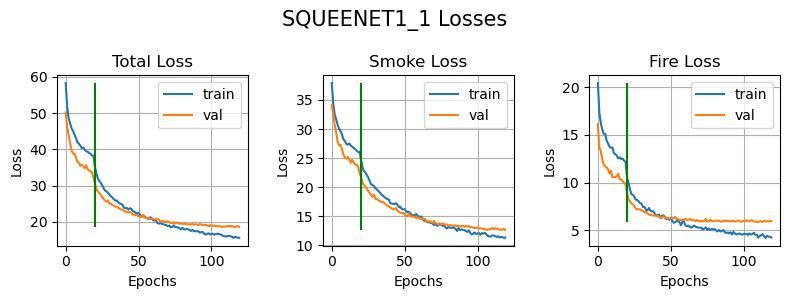

In [28]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle(MODEL + ' Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_total_loss), ymax=max(train_total_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_smoke_loss), ymax=max(train_smoke_loss), color='green')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.vlines(x=20, ymin=min(val_fire_loss), ymax=max(train_fire_loss), color='green')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + MODEL + "_losses.png")
plt.show()

# Export to ONNX

In [29]:
model_freeze.eval()
torch_input = torch.rand(1, 3, IMG_H, IMG_W)
model.to('cpu')
onnx_program = torch.onnx.dynamo_export(model_freeze, torch_input)

/opt/conda/envs/pytorch_23/lib/python3.10/site-packages/torch/onnx/_internal/exporter.py:136: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(


In [30]:
onnx_program.save("squeezenet_classifier.onnx")

# Metrics to evaluate ONNX

In [35]:
import onnxruntime

In [31]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to('cpu')
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to('cpu')
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to('cpu')
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to('cpu')

f1_metric_mean = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                               threshold = 0.5, 
                                                               average = 'macro').to('cpu')

# Eval function

In [32]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [36]:
def eval_classifier_onnx(loader, model_name):

    ort_session = onnxruntime.InferenceSession(model_name, providers=["CPUExecutionProvider"])

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    f1_metric_mean.reset()
    
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (img, label) in enumerate(loop):

        for idx in range(BATCH_SIZE):
            
            ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img[idx].unsqueeze(dim=0))}
            yhat = ort_session.run(None, ort_inputs)
            yhat = np.array(yhat)
            #yhat = torch.tensor(yhat).squeeze(dim=0)
            yhat = torch.sigmoid(torch.tensor(yhat).squeeze(dim=0))
            target = label[idx].unsqueeze(dim=0)

            precision_metric.update(yhat, target)
            recall_metric.update(yhat, target)
            accuracy_metric.update(yhat, target)
            f1_metric.update(yhat, target)
            f1_metric_mean.update(yhat, target)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    f1_mean = f1_metric_mean.compute()

    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    f1_metric_mean.reset()

    print(f'SMOKE -> Precision: {precision[0]:.4f} - Recall: {recall[0]:.4f} - Accuracy: {accuracy[0]:.4f} - F1: {f1[0]:.4f}')
    print(f'FIRE -> Precision: {precision[1]:.4f} - Recall: {recall[1]:.4f} - Accuracy: {accuracy[1]:.4f} - F1: {f1[1]:.4f}')
    print(f'Mean F1 Score: {f1_mean.item():.4f}')

    logger.info(f'SMOKE -> Precision: {precision[0]:.4f} - Recall: {recall[0]:.4f} - Accuracy: {accuracy[0]:.4f} - F1: {f1[0]:.4f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.4f} - Recall: {recall[1]:.4f} - Accuracy: {accuracy[1]:.4f} - F1: {f1[1]:.4f}')
    logger.info(f'Mean F1 Score: {f1_mean.item():.4f}')
    
    return (
        {
        'Accuracy': [accuracy[0].item(), accuracy[1].item()],
        'Precision': [precision[0].item(), precision[1].item()],
        'Recall': [recall[0].item(), recall[1].item()],
        'F1': [f1[0].item(), f1[1].item()],
        'F1 mean': f1_mean.item(),
        }
    )

In [37]:
logger.info("\nONNX Metrics")
onnx_metrics = eval_classifier_onnx(val_loader, 'squeezenet_classifier.onnx')

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:33<00:00,  2.01it/s]

SMOKE -> Precision: 0.9272 - Recall: 0.9321 - Accuracy: 0.9321 - F1: 0.9297
FIRE -> Precision: 0.9480 - Recall: 0.9369 - Accuracy: 0.9704 - F1: 0.9425
Mean F1 Score: 0.9361


# Compare to Pytorch Metrics

In [40]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

In [41]:
model.to(DEVICE)
with torch.no_grad():
    val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                         model=model,                         
                                                                         loss_fn=loss_fn,
                                                                         device=DEVICE)

Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 24.72it/s]

Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
18.633      |12.669      |5.965       

SMOKE -> Precision: 0.927 - Recall: 0.932 - Accuracy: 0.932 - F1: 0.930
FIRE -> Precision: 0.948 - Recall: 0.937 - Accuracy: 0.970 - F1: 0.942
